**Airbnb Calendar -Time-Series Analysis**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [83]:
#Read in libraries
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in Data**

In [84]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

#Read in Airbnb Calendar data
calendar = pd.read_csv(path + '2020_0130_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

#Read in Zillow data
zillow = pd.read_csv(path + '2020_0130_Zillow_Cleaned.csv', parse_dates=['Date'],
                     index_col=0, sep=',')

**Set notebook preferences**

In [85]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preview Data

## Airbnb Calendar Data

In [86]:
#View shape and preview calendar data
print(calendar.shape)

(14125242, 5)


## Zillow Data

In [87]:
#View shape and preview calendar data
print(zillow.shape)
zillow.head()

(277104, 9)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03-01,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04-01,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05-01,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06-01,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07-01,1225


# Time Series Analysis

## Date preparation, indexing and feature engineering

### Calendar data preparation

In [88]:
#Set date as index in calendar
calendar.set_index('date', inplace=True)

In [89]:
#Extract data from index and assign to columns 
calendar['year'] = calendar.index.year
calendar['month'] = calendar.index.month
calendar['day'] = calendar.index.day
calendar['weekday'] = calendar.index.weekday
calendar['month_year'] = calendar.index.to_period('M')

#Check
calendar.head()

,index,available,listing_id,price,year,month,day,weekday,month_year
date,,,,,,,,,
2019-04-05,0,1,21190709,5000,2019,4,5,4,2019-04
2019-04-04,1,1,21190709,5000,2019,4,4,3,2019-04
2019-04-03,2,1,21190709,5000,2019,4,3,2,2019-04
2019-04-02,3,1,21190709,5000,2019,4,2,1,2019-04
2019-04-01,4,1,21190709,5000,2019,4,1,0,2019-04


### Zillow data preparation

In [90]:
#Set date as index
zillow.set_index('Date', inplace=True)

zillow.head()

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent
Date,,,,,,,,
2010-03-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-04-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-05-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-06-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-07-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1225


### Airbnb Growth in SF(12/2018 - 12/2019)?

In [91]:
calendar[calendar['available'] == 1].sort_values(by = 'date')

,index,available,listing_id,price,year,month,day,weekday,month_year
date,,,,,,,,,
2018-01-01,45276890,1,21606897,39,2018,1,1,0,2018-01
2018-01-01,43172955,1,4263821,65,2018,1,1,0,2018-01
2018-01-01,44010340,1,2802480,499,2018,1,1,0,2018-01
2018-01-01,42830259,1,5031525,200,2018,1,1,0,2018-01
2018-01-01,44009610,1,6092935,300,2018,1,1,0,2018-01
...,...,...,...,...,...,...,...,...,...
2019-12-31,26115941,1,25449566,312,2019,12,31,1,2019-12
2019-12-31,3638957,1,23942828,80,2019,12,31,1,2019-12
2019-12-31,31751547,1,5212469,202,2019,12,31,1,2019-12


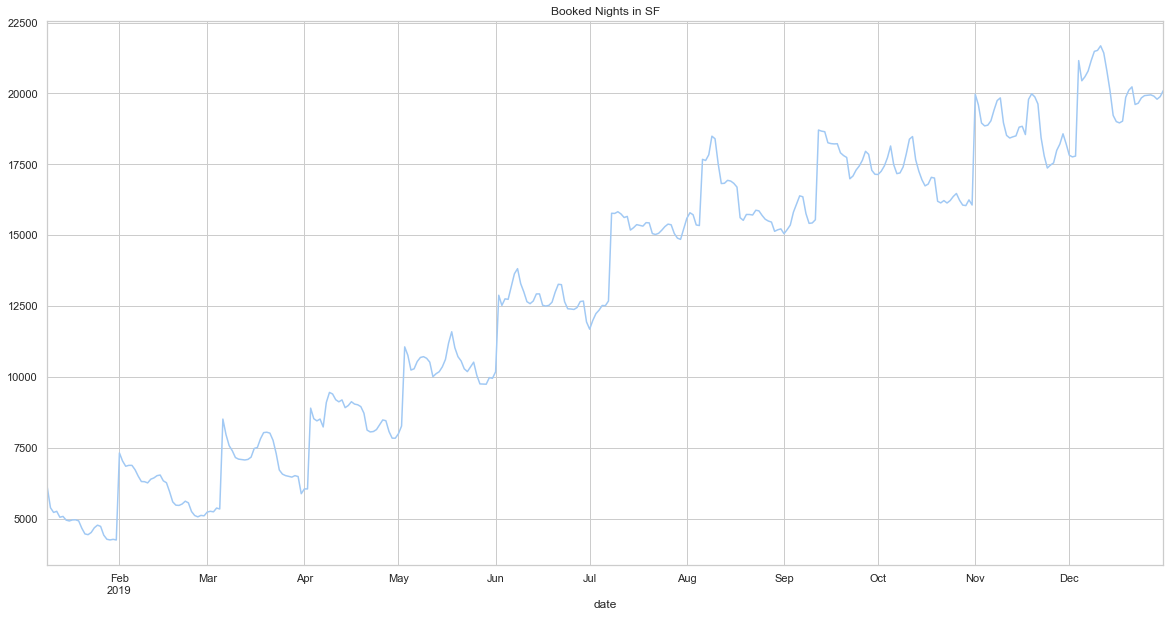

In [97]:
#Store count of booked evenings in Sf per night 
booked_nights = calendar[calendar['available'] == 0].groupby(['date'])['available'].count()
booked_nights.plot(title = 'Booked Nights in SF', figsize = (20,10))
#Group last year by month_year and get a count of unique listings per day
#last_year_daily = booked_nights.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()
#booked_nights.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()
# #Rename columns
# last_year_daily =last_year_daily.rename(columns = {'nunique': 'listings'})

# last_year_daily

In [81]:
#Weekly listings
print(last_year_daily.shape)
last_year_daily.head()

NameError: name 'last_year_daily' is not defined

In [ ]:
rolling_mean=last_year_daily.rolling(window=7,min_periods=1).mean()
rolling_mean = rolling_mean.rename(columns={'listings':'rolling_wk_avg'})

In [ ]:
rolling_mean.head()

In [ ]:
test= last_year_daily.join(rolling_mean)

In [ ]:
test.head()

In [ ]:
test = test.drop(columns='listings')

In [ ]:
#Capture unique listings a month
last_year_monthly = calendar.groupby(['month_year'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year_monthly =last_year_monthly.rename(columns = {'nunique': 'listings'})

In [ ]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Plot daily unique listings data
ax = last_year_daily.plot(x='date', y='listings', kind = 'line',style='o-', markersize=.5,
          label= 'Daily Unique Listings',figsize = (15,10),
         linewidth = 1.5)

test.plot(x='date', y='rolling_wk_avg', kind = 'line',style='o-', markersize=.5,
          label= 'Weekly Unique Listings',figsize = (15,10),
         linewidth = 1.5, ax=ax)

#plot montly average
last_year_monthly.plot(x='month_year', y='listings',kind = 'line',style='o-', markersize= 7,
          label= 'Monthly Unique Listings', linewidth = 1.5 , ax=ax)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Growth of Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year_monthly['month_year'], last_year_monthly['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(0,0), ha='left')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

In [ ]:
#datamusings #artificialintelligence
#softwareengineering #programmingisfun
#fullstack #sql #codeismylife #developerlife
#developerslife #codingpics #learntocode #java
#bigdata #webdevelopers #pythoncode
#analytics #reactjs #devlife


# Median rent across the United States

In [ ]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,5))
sf_zillow.groupby('Date')['Median_Rent'].mean().plot(kind = 'line', color = 'r')

zillow.groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color= 'g')#natl average

plt.title('Comparing rent accross the Unites states vs SF(in airbnb specofically)')
#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
zillow[zillow.SizeRank < 2].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'b')#this is compared to CA
zillow[zillow.SizeRank < 10].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'black')#purp(top 10 largest in US)

In [ ]:
#Group last year by month_year and get a count of unique listings per day
last_year_daily = calendar.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year_daily =last_year_daily.rename(columns = {'nunique': 'listings'})

In [ ]:
#Weekly listings
print(last_year_daily.shape)
last_year_daily.head()

In [ ]:
rolling_mean=last_year_daily.rolling(window=7,min_periods=1).mean()
rolling_mean = rolling_mean.rename(columns={'listings':'rolling_wk_avg'})

In [ ]:
rolling_mean.head()

In [ ]:
test= last_year_daily.join(rolling_mean)

In [ ]:
test.head()

In [ ]:
test = test.drop(columns='listings')

In [ ]:
#Capture unique listings a month
last_year_monthly = calendar.groupby(['month_year'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year_monthly =last_year_monthly.rename(columns = {'nunique': 'listings'})

In [ ]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Plot daily unique listings data
ax = last_year_daily.plot(x='date', y='listings', kind = 'line',style='o-', markersize=.5,
          label= 'Daily Unique Listings',figsize = (15,10),
         linewidth = 1.5)

test.plot(x='date', y='rolling_wk_avg', kind = 'line',style='o-', markersize=.5,
          label= 'Weekly Unique Listings',figsize = (15,10),
         linewidth = 1.5, ax=ax)

#plot montly average
last_year_monthly.plot(x='month_year', y='listings',kind = 'line',style='o-', markersize= 7,
          label= 'Monthly Unique Listings', linewidth = 1.5 , ax=ax)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Growth of Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year_monthly['month_year'], last_year_monthly['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(0,0), ha='left')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

Might be worth looking at a few years worth of reviews and calendar data to see the demand and  growth over time

In [ ]:
#Set Date as index for zillow data
zillow.set_index(keys = 'Date', inplace=True)

In [ ]:
#Extract date info from index and assign to zillow
zillow['Year'] = zillow.index.year
zillow['Month'] = zillow.index.month
zillow['Weekday_Name'] = zillow.index.weekday_name

In [ ]:
zillow.head()

# Time Series Analysis

For this analysis, we will isolate the rows in our Zillow data that are in the zipcode or city of the listings data.

In [ ]:
zillow = zillow.loc['2011-09-01':'2019-11-01']

In [ ]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,5))
sf_zillow.groupby('Date')['Median_Rent'].mean().plot(kind = 'line', color = 'r')

zillow.groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color= 'g')#natl average

plt.title('Comparing rent accross the Unites states vs SF(in airbnb specofically)')
#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
zillow[zillow.SizeRank < 2].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'b')#this is compared to CA
zillow[zillow.SizeRank < 10].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'black')#purp(top 10 largest in US)

Airbnb monthly rent vs bay area rent 

In [ ]:
#Capture id and monthly_price from listings data for merge with calendar data
listings_merge = listings[['id','monthly_price']]



In [ ]:
calendar_merge = calendar[['listing_id','price','month_year','year','month']]
calendar_merge.reset_index(inplace = True)

In [ ]:
monthly_listings = calendar_merge.merge(listings_merge, left_on='listing_id', right_on='id')

In [ ]:
monthly_listings=monthly_listings[-monthly_listings.monthly_price.isna()]

monthly_listings.drop_duplicates(inplace = True)

In [ ]:
print(monthly_listings.shape)
monthly_listings.head()

In [ ]:
monthly_listings.set_index('date', inplace=True)

monthly_listings.sort_index(inplace=True)

In [ ]:
monthly_listings.tail()

In [ ]:
monthly_listings.loc['2018-12-01':'2019-11-01'].groupby('month_year')['monthly_price'].mean().plot(color = 'g')

sf_zillow.loc['2018-12-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line')

In [ ]:
#test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot(kind = 'box')
sns.boxplot(x='month_year', y = 'price', data = monthly_listings)

In [ ]:
sf_zillow.sort_index(inplace=True)

In [ ]:
sf_zillow.tail()

In [ ]:
calendar.head()

* Comparing monthly rent of airbnb to zillow

### Principal Component Analysis